In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.cm as cm
plt.style.use("ggplot")
from datetime import datetime
from IPython.display import display
import calendar
from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox, kurtosis
from sklearn.preprocessing import StandardScaler
import math
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import datetime


In [2]:
cust = pd.read_csv('Customer_info.csv')
disc = pd.read_csv('Discount_info.csv')
mkt = pd.read_csv('Marketing_info.csv')
sales = pd.read_csv('Onlinesales_info.csv')
tax = pd.read_csv('Tax_info.csv')

In [3]:
sales['거래날짜'] = pd.to_datetime(sales['거래날짜'])
mkt['날짜'] = pd.to_datetime(mkt['날짜'])

from datetime import datetime
sales['월'] = sales['거래날짜'].map(lambda x: datetime.strftime(x, '%b'))

dateDict = {0: '월요일', 1:'화요일', 2:'수요일', 3:'목요일', 4:'금요일', 5:'토요일', 6:'일요일'}
sales['요일'] = sales['거래날짜'].map(lambda x: dateDict[datetime.weekday(x)])

sales['구매금액'] = sales['수량']*sales['평균금액']

In [4]:
df1 = sales.merge(cust, on=['고객ID'])
df2 = df1.merge(disc, on=['월','제품카테고리'])
df3 = df2.merge(mkt, left_on=['거래날짜'], right_on=['날짜'])
df3.drop('날짜', axis=1, inplace=True) # 중복컬럼 제거
df = df3.merge(tax, on=['제품카테고리'])
df

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,월,요일,구매금액,성별,고객지역,가입기간,쿠폰코드,할인율,오프라인비용,온라인비용,GST
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,Jan,화요일,153.71,남,Chicago,12,ELEC10,10,4500,2424.50,0.10
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,Jan,화요일,153.71,남,Chicago,12,ELEC10,10,4500,2424.50,0.10
2,USER_1358,Transaction_0013,2019-01-01,Product_0983,Nest-USA,2,122.77,6.5,Not Used,Jan,화요일,245.54,남,Chicago,12,ELEC10,10,4500,2424.50,0.10
3,USER_1358,Transaction_0015,2019-01-01,Product_0984,Nest-USA,1,81.50,6.5,Clicked,Jan,화요일,81.50,남,Chicago,12,ELEC10,10,4500,2424.50,0.10
4,USER_1358,Transaction_0016,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Clicked,Jan,화요일,153.71,남,Chicago,12,ELEC10,10,4500,2424.50,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52519,USER_0535,Transaction_21916,2019-11-26,Product_0990,Nest,1,199.00,6.5,Used,Nov,화요일,199.00,남,Chicago,22,NE20,20,3000,1642.31,0.05
52520,USER_0535,Transaction_21918,2019-11-26,Product_0992,Nest,1,99.00,6.5,Used,Nov,화요일,99.00,남,Chicago,22,NE20,20,3000,1642.31,0.05
52521,USER_0535,Transaction_21919,2019-11-26,Product_0994,Nest,1,349.00,6.5,Clicked,Nov,화요일,349.00,남,Chicago,22,NE20,20,3000,1642.31,0.05
52522,USER_0535,Transaction_21920,2019-11-26,Product_0990,Nest,3,199.00,6.5,Used,Nov,화요일,597.00,남,Chicago,22,NE20,20,3000,1642.31,0.05


### EDA
1. ARPPU, 고객 수, 매출

In [5]:
arppu = df.groupby(['월']).agg({'구매금액' : 'sum', '고객ID' : 'nunique', '거래ID': 'count'}).reset_index()
arppu['arppu'] = arppu['구매금액'] / arppu['고객ID']
arppu.style.background_gradient(cmap = 'Greys')


,월,구매금액,고객ID,거래ID,arppu
0,Apr,396844.170000,224,4098,1771.625759
1,Aug,399446.030000,300,6112,1331.486767
2,Dec,523258.190000,236,4502,2217.195720
3,Feb,308323.650000,109,3245,2828.657339
4,Jan,401054.830000,215,4023,1865.371302
5,Jul,369513.590000,235,5196,1572.398255
6,Jun,319081.750000,259,4159,1231.975869
7,Mar,345686.730000,208,4290,1661.955433
8,May,303956.780000,200,4516,1519.783900
9,Nov,508582.660000,188,3957,2705.226915


<Axes: >

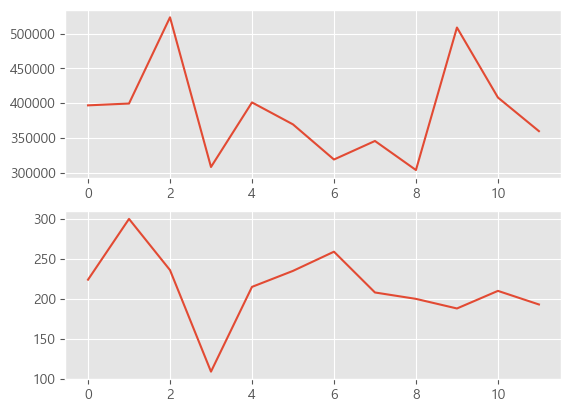

In [6]:
plt.subplot(211)
arppu['구매금액'].plot()
plt.subplot(212)
arppu['고객ID'].plot()

<Axes: >

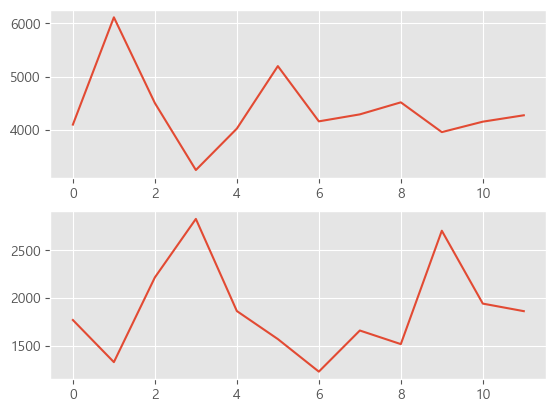

In [7]:
plt.subplot(211)
arppu['거래ID'].plot()
plt.subplot(212)
arppu['arppu'].plot()

In [8]:
object_col = df.select_dtypes('object').columns.to_list()

In [9]:
# 고객 한 명이 여러 제품을 구매한 데이터가 많아 보인다 -> 연관분석(장바구니 분석) 가능해 보임
for i in object_col :
    print(f'변수 {i}의 고유값 개수 : {df[i].nunique()}')

변수 고객ID의 고유값 개수 : 1468
변수 거래ID의 고유값 개수 : 25000
변수 제품ID의 고유값 개수 : 1135
변수 제품카테고리의 고유값 개수 : 16
변수 쿠폰상태의 고유값 개수 : 3
변수 월의 고유값 개수 : 12
변수 요일의 고유값 개수 : 7
변수 성별의 고유값 개수 : 2
변수 고객지역의 고유값 개수 : 5
변수 쿠폰코드의 고유값 개수 : 45


In [10]:
# 결측치 x
df.isnull().sum()

고객ID      0
거래ID      0
거래날짜      0
제품ID      0
제품카테고리    0
수량        0
평균금액      0
배송료       0
쿠폰상태      0
월         0
요일        0
구매금액      0
성별        0
고객지역      0
가입기간      0
쿠폰코드      0
할인율       0
오프라인비용    0
온라인비용     0
GST       0
dtype: int64

In [11]:
# 고객별 제품 카테고리별 소비율 (카테고리별 구매금액의 합계)
df_pv = df.pivot_table(index = '고객ID', columns='제품카테고리', values='구매금액', aggfunc='sum').fillna(0).reset_index()
df_pv

제품카테고리,고객ID,Accessories,Android,Apparel,Bags,Bottles,Drinkware,Gift Cards,Headgear,Housewares,Lifestyle,Nest,Nest-Canada,Nest-USA,Notebooks & Journals,Office,Waze
0,USER_0000,0.00,0.0,19.99,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.00,11.00,0.00
1,USER_0001,2.99,0.0,8902.01,27.94,0.00,31.93,0.0,37.98,0.0,9.57,628.0,0.00,3917.00,0.00,255.10,0.00
2,USER_0002,0.00,0.0,49.74,244.39,0.00,418.24,0.0,0.00,0.0,29.99,0.0,0.00,475.00,0.00,224.76,0.00
3,USER_0003,0.00,0.0,173.59,0.00,0.00,0.00,0.0,32.60,0.0,0.00,0.0,303.76,850.12,0.00,0.00,0.00
4,USER_0004,0.00,0.0,276.30,4.99,0.00,47.37,0.0,0.00,0.0,14.00,398.0,0.00,655.00,0.00,46.81,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,USER_1463,0.00,0.0,156.66,0.00,0.00,10.39,0.0,0.00,0.0,0.00,0.0,0.00,0.00,359.70,0.00,0.00
1464,USER_1464,27.18,0.0,344.32,167.97,2.39,70.36,0.0,55.81,0.0,0.00,0.0,0.00,1259.00,166.12,201.53,21.57
1465,USER_1465,0.00,0.0,98.38,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.00,3.18,0.00
1466,USER_1466,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,298.00,0.00,0.00,0.00


### L 추출

In [12]:
df_last = df.groupby('고객ID')['거래날짜'].max().reset_index()
df_first = df.groupby('고객ID')['거래날짜'].min().reset_index()
df_length = df_first.merge(df_last, on=['고객ID'])
df_length['L'] = df_length['거래날짜_y'] - df_length['거래날짜_x']
lrfm_l = df_length[['고객ID','L']]
lrfm_l



,고객ID,L
0,USER_0000,0 days
1,USER_0001,223 days
2,USER_0002,119 days
3,USER_0003,0 days
4,USER_0004,0 days
...,...,...
1463,USER_1463,0 days
1464,USER_1464,105 days
1465,USER_1465,76 days
1466,USER_1466,0 days


### R 추출

In [13]:
# 기준일은 19-12-31
df_last['R'] = (pd.to_datetime('2019-12-31') - df_last['거래날짜'])
lrfm_r = df_last[['고객ID','R']]
lrfm_r


,고객ID,R
0,USER_0000,107 days
1,USER_0001,59 days
2,USER_0002,73 days
3,USER_0003,17 days
4,USER_0004,107 days
...,...,...
1463,USER_1463,270 days
1464,USER_1464,87 days
1465,USER_1465,194 days
1466,USER_1466,69 days


### M 추출

In [14]:
lrfm_m = sales.groupby('고객ID')['구매금액'].sum().reset_index()
lrfm_m.rename(columns={'구매금액' : 'M'}, inplace=True)
lrfm_m

,고객ID,M
0,USER_0000,30.99
1,USER_0001,13834.90
2,USER_0002,1442.12
3,USER_0003,1360.07
4,USER_0004,1442.47
...,...,...
1463,USER_1463,544.34
1464,USER_1464,2363.05
1465,USER_1465,101.56
1466,USER_1466,298.00


### F 추출

In [15]:
lrfm_f = sales.groupby('고객ID')['거래ID'].count().reset_index()
lrfm_f.rename(columns={'거래ID' : 'F'},inplace = True)
lrfm_f

,고객ID,F
0,USER_0000,2
1,USER_0001,60
2,USER_0002,23
3,USER_0003,17
4,USER_0004,36
...,...,...
1463,USER_1463,7
1464,USER_1464,40
1465,USER_1465,8
1466,USER_1466,1


### lrfm 조인

In [16]:
lrfm = lrfm_l.merge(lrfm_r, on=['고객ID']).merge(lrfm_f, on=['고객ID']).merge(lrfm_m, on=['고객ID'])
lrfm

,고객ID,L,R,F,M
0,USER_0000,0 days,107 days,2,30.99
1,USER_0001,223 days,59 days,60,13834.90
2,USER_0002,119 days,73 days,23,1442.12
3,USER_0003,0 days,17 days,17,1360.07
4,USER_0004,0 days,107 days,36,1442.47
...,...,...,...,...,...
1463,USER_1463,0 days,270 days,7,544.34
1464,USER_1464,105 days,87 days,40,2363.05
1465,USER_1465,76 days,194 days,8,101.56
1466,USER_1466,0 days,69 days,1,298.00


In [17]:
lrfm['L']=lrfm['L'].astype(str)
lrfm['L'] = lrfm['L'].str.extract(r'(\d+)').astype(int) # days 문자열 제거
lrfm['R']=lrfm['R'].astype(str)
lrfm['R'] = lrfm['R'].str.extract(r'(\d+)').astype(int)
lrfm

,고객ID,L,R,F,M
0,USER_0000,0,107,2,30.99
1,USER_0001,223,59,60,13834.90
2,USER_0002,119,73,23,1442.12
3,USER_0003,0,17,17,1360.07
4,USER_0004,0,107,36,1442.47
...,...,...,...,...,...
1463,USER_1463,0,270,7,544.34
1464,USER_1464,105,87,40,2363.05
1465,USER_1465,76,194,8,101.56
1466,USER_1466,0,69,1,298.00


In [18]:
# 제품 카테고리 피봇한 테이블에 lrfm 조인
df_pv = df_pv.merge(lrfm, on = ['고객ID'])
df_pv

,고객ID,Accessories,Android,Apparel,Bags,Bottles,Drinkware,Gift Cards,Headgear,Housewares,...,Nest,Nest-Canada,Nest-USA,Notebooks & Journals,Office,Waze,L,R,F,M
0,USER_0000,0.00,0.0,19.99,0.00,0.00,0.00,0.0,0.00,0.0,...,0.0,0.00,0.00,0.00,11.00,0.00,0,107,2,30.99
1,USER_0001,2.99,0.0,8902.01,27.94,0.00,31.93,0.0,37.98,0.0,...,628.0,0.00,3917.00,0.00,255.10,0.00,223,59,60,13834.90
2,USER_0002,0.00,0.0,49.74,244.39,0.00,418.24,0.0,0.00,0.0,...,0.0,0.00,475.00,0.00,224.76,0.00,119,73,23,1442.12
3,USER_0003,0.00,0.0,173.59,0.00,0.00,0.00,0.0,32.60,0.0,...,0.0,303.76,850.12,0.00,0.00,0.00,0,17,17,1360.07
4,USER_0004,0.00,0.0,276.30,4.99,0.00,47.37,0.0,0.00,0.0,...,398.0,0.00,655.00,0.00,46.81,0.00,0,107,36,1442.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,USER_1463,0.00,0.0,156.66,0.00,0.00,10.39,0.0,0.00,0.0,...,0.0,0.00,0.00,359.70,0.00,0.00,0,270,7,544.34
1464,USER_1464,27.18,0.0,344.32,167.97,2.39,70.36,0.0,55.81,0.0,...,0.0,0.00,1259.00,166.12,201.53,21.57,105,87,40,2363.05
1465,USER_1465,0.00,0.0,98.38,0.00,0.00,0.00,0.0,0.00,0.0,...,0.0,0.00,0.00,0.00,3.18,0.00,76,194,8,101.56
1466,USER_1466,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,...,0.0,0.00,298.00,0.00,0.00,0.00,0,69,1,298.00


### 구매 패턴 군집 분석 (진행중)

In [19]:
sales['CNT'] = 1
# 고객, 요일별로 조합의 발생 횟수를 카운트
df_wod = sales.groupby(['고객ID','요일'])['CNT'].count().reset_index()
df_wod

,고객ID,요일,CNT
0,USER_0000,일요일,2
1,USER_0001,금요일,4
2,USER_0001,일요일,31
3,USER_0001,토요일,25
4,USER_0002,토요일,23
...,...,...,...
2669,USER_1465,금요일,7
2670,USER_1465,목요일,1
2671,USER_1466,수요일,1
2672,USER_1467,목요일,45


In [20]:
df_wod_pv = df_wod.pivot_table(index = '고객ID', columns = '요일', values='CNT', aggfunc='sum').fillna(0).reset_index()
df_wod_pv

요일,고객ID,금요일,목요일,수요일,월요일,일요일,토요일,화요일
0,USER_0000,0.0,0.0,0.0,0.0,2.0,0.0,0.0
1,USER_0001,4.0,0.0,0.0,0.0,31.0,25.0,0.0
2,USER_0002,0.0,0.0,0.0,0.0,0.0,23.0,0.0
3,USER_0003,0.0,0.0,0.0,0.0,0.0,17.0,0.0
4,USER_0004,0.0,0.0,0.0,0.0,36.0,0.0,0.0
...,...,...,...,...,...,...,...,...
1463,USER_1463,7.0,0.0,0.0,0.0,0.0,0.0,0.0
1464,USER_1464,0.0,0.0,0.0,0.0,26.0,14.0,0.0
1465,USER_1465,7.0,1.0,0.0,0.0,0.0,0.0,0.0
1466,USER_1466,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [21]:
df_wod_pv = df_wod_pv.apply(pd.to_numeric, errors='coerce') #
df_wod_pv['전체요일횟수'] = df_wod_pv.sum(axis='columns') # 각 행의요일별 횟수를 합산해서 전체요일횟수 추가

In [22]:
df_wod['고객ID번호'] = df_wod['고객ID'].str.extract(r'(\d+)').astype(int)

In [23]:
df_wod_pv['월_비율'] = round(df_wod_pv['월요일'] / df_wod_pv['전체요일횟수'],2)
df_wod_pv['화_비율'] = round(df_wod_pv['화요일'] / df_wod_pv['전체요일횟수'],2)
df_wod_pv['수_비율'] = round(df_wod_pv['수요일'] / df_wod_pv['전체요일횟수'],2)
df_wod_pv['목_비율'] = round(df_wod_pv['목요일'] / df_wod_pv['전체요일횟수'],2)
df_wod_pv['금_비율'] = round(df_wod_pv['금요일'] / df_wod_pv['전체요일횟수'],2)
df_wod_pv['토_비율'] = round(df_wod_pv['토요일'] / df_wod_pv['전체요일횟수'],2)
df_wod_pv['일_비율'] = round(df_wod_pv['일요일'] / df_wod_pv['전체요일횟수'],2)
df_wod_pv

요일,고객ID,금요일,목요일,수요일,월요일,일요일,토요일,화요일,전체요일횟수,월_비율,화_비율,수_비율,목_비율,금_비율,토_비율,일_비율
0,NaN,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.00,0.0,0.0,0.00,0.00,0.00,1.00
1,NaN,4.0,0.0,0.0,0.0,31.0,25.0,0.0,60.0,0.00,0.0,0.0,0.00,0.07,0.42,0.52
2,NaN,0.0,0.0,0.0,0.0,0.0,23.0,0.0,23.0,0.00,0.0,0.0,0.00,0.00,1.00,0.00
3,NaN,0.0,0.0,0.0,0.0,0.0,17.0,0.0,17.0,0.00,0.0,0.0,0.00,0.00,1.00,0.00
4,NaN,0.0,0.0,0.0,0.0,36.0,0.0,0.0,36.0,0.00,0.0,0.0,0.00,0.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,NaN,7.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.00,0.0,0.0,0.00,1.00,0.00,0.00
1464,NaN,0.0,0.0,0.0,0.0,26.0,14.0,0.0,40.0,0.00,0.0,0.0,0.00,0.00,0.35,0.65
1465,NaN,7.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,0.00,0.0,0.0,0.12,0.88,0.00,0.00
1466,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.00,0.0,1.0,0.00,0.00,0.00,0.00


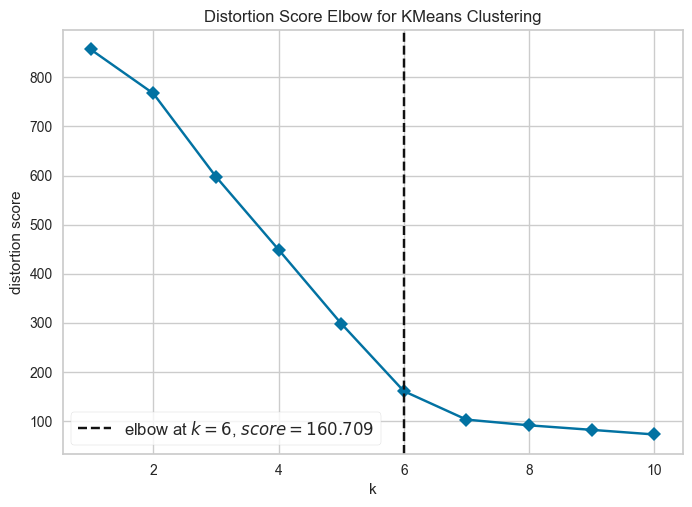

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [24]:
km_wod = df_wod_pv.iloc[:,10:]

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

k=0
kmeans = KMeans(n_clusters=k, random_state=17)
visualizer = KElbowVisualizer(kmeans, k=(1,11), timings=False)
visualizer.fit(km_wod)
visualizer.show()

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples

for k in range(2, 11):
    fig, ax = plt.subplots(1, 1)
    kmeans = KMeans(n_clusters=k, random_state=17).fit(km_wod)

    silhouette_avg = silhouette_score(km_wod, kmeans.labels_)
    print(f'cluster : {k} // silhouette index {silhouette_avg}')

    silhouette_vals = silhouette_samples(km_wod, kmeans.labels_)
    y_ticks = []
    y_lower = y_upper = 0
    for c_num in np.unique(kmeans.labels_):
        cluster_silhouette_vals = silhouette_vals[kmeans.labels_==c_num]
        y_upper += len(cluster_silhouette_vals)
        cluster_silhouette_vals.sort() # numpy array는 sort 메소드를 이용하면 오름차순으로 정렬된 형태로 바뀜

        ax.barh(range(y_lower, y_upper), cluster_silhouette_vals, height=1)
        y_lower += len(cluster_silhouette_vals)

In [25]:
km_wod = df_wod_pv.iloc[:,10:]

k = 7

# 그룹 수, random_state 설정
km_model = KMeans(n_clusters = k, random_state = 17)

# 정규화된 데이터에 학습
km_model.fit(km_wod)

# 클러스터링 결과 각 데이터가 몇 번째 그룹에 속하는지 저장
km_wod['군집'] = km_model.fit_predict(km_wod)

In [26]:
km_wod['군집'].value_counts()

군집
2    260
1    257
4    217
3    208
5    203
6    194
0    129
Name: count, dtype: int64

In [27]:
km_wod

요일,화_비율,수_비율,목_비율,금_비율,토_비율,일_비율,군집
0,0.0,0.0,0.00,0.00,0.00,1.00,3
1,0.0,0.0,0.00,0.07,0.42,0.52,3
2,0.0,0.0,0.00,0.00,1.00,0.00,6
3,0.0,0.0,0.00,0.00,1.00,0.00,6
4,0.0,0.0,0.00,0.00,0.00,1.00,3
...,...,...,...,...,...,...,...
1463,0.0,0.0,0.00,1.00,0.00,0.00,1
1464,0.0,0.0,0.00,0.00,0.35,0.65,3
1465,0.0,0.0,0.12,0.88,0.00,0.00,1
1466,0.0,1.0,0.00,0.00,0.00,0.00,5


c:\Users\zxcv2\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from current font.
  fig.canvas.draw()
c:\Users\zxcv2\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current font.
  fig.canvas.draw()
c:\Users\zxcv2\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from current font.
  fig.canvas.draw()
c:\Users\zxcv2\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.draw()
c:\Users\zxcv2\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 47785 (\N{HANGUL SYLLABLE MOG}) missing from current font.
  fig.canvas.draw()
c:\Users\zxcv2\AppData\Local\Programs\Pyth

<Axes: xlabel='요일', ylabel='군집'>

C:\Users\zxcv2\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:82: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from current font.
  func(*args, **kwargs)
C:\Users\zxcv2\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:82: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current font.
  func(*args, **kwargs)
C:\Users\zxcv2\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:82: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from current font.
  func(*args, **kwargs)
C:\Users\zxcv2\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:82: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  func(*args, **kwargs)
C:\Users\zxcv2\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:82: UserWarning: Glyph 47785 (\N{HANGUL SYLLABLE MOG}) missing from current font.
  func(*args, **kwargs)
C:\Users\zxcv2\AppData\Roaming\Python\Python311

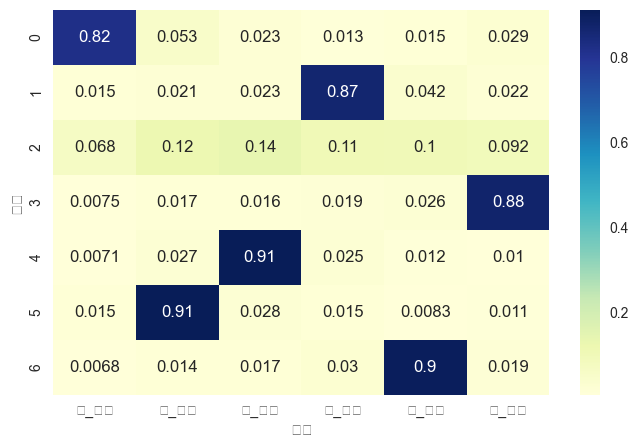

In [28]:
plt.figure(figsize=(8,5))
sns.heatmap(km_wod.groupby('군집').mean(), annot=True, cmap="YlGnBu")

### LRFM 클러스터링

In [29]:
# L,R,F,M만 추출
cl_df = df_pv[['L','R','F','M']]

In [30]:
cl_df

,L,R,F,M
0,0,107,2,30.99
1,223,59,60,13834.90
2,119,73,23,1442.12
3,0,17,17,1360.07
4,0,107,36,1442.47
...,...,...,...,...
1463,0,270,7,544.34
1464,105,87,40,2363.05
1465,76,194,8,101.56
1466,0,69,1,298.00


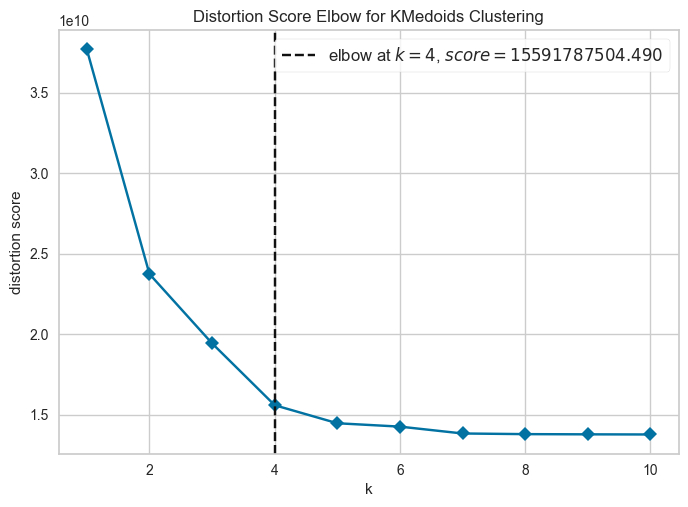

<Axes: title={'center': 'Distortion Score Elbow for KMedoids Clustering'}, xlabel='k', ylabel='distortion score'>

In [31]:
from sklearn_extra.cluster import KMedoids
from yellowbrick.cluster import KElbowVisualizer

k=2
kmedoids = KMedoids(n_clusters=k, random_state=17).fit(cl_df)
visualizer = KElbowVisualizer(kmedoids, k=(1,11), timings=False)
visualizer.fit(cl_df)
visualizer.show()

cluster : 3 // silhouette index 0.5304822425486643
cluster : 4 // silhouette index 0.5304222328914627
cluster : 5 // silhouette index 0.48546871162693395
cluster : 6 // silhouette index 0.4630090282696916
cluster : 7 // silhouette index 0.4514020223105575
cluster : 8 // silhouette index 0.4325344152394421
cluster : 9 // silhouette index 0.4124553030460925
cluster : 10 // silhouette index 0.39494667583050935


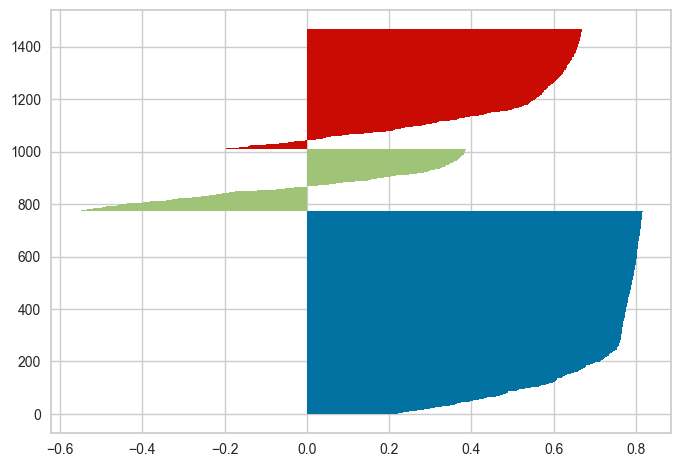

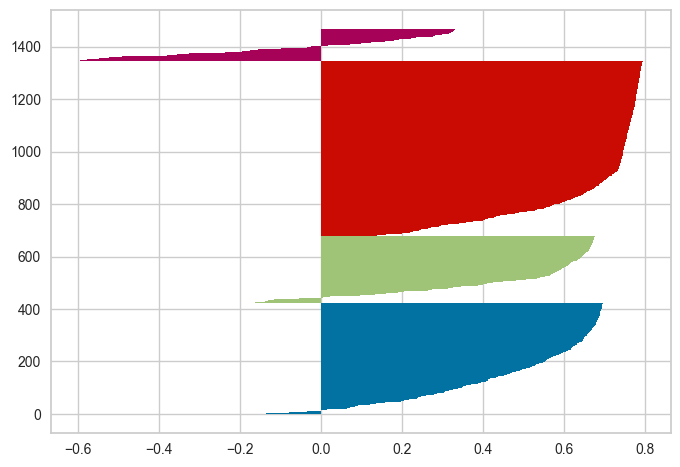

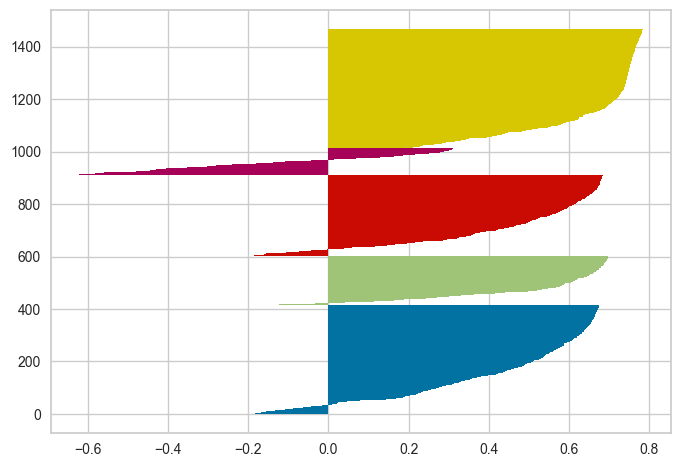

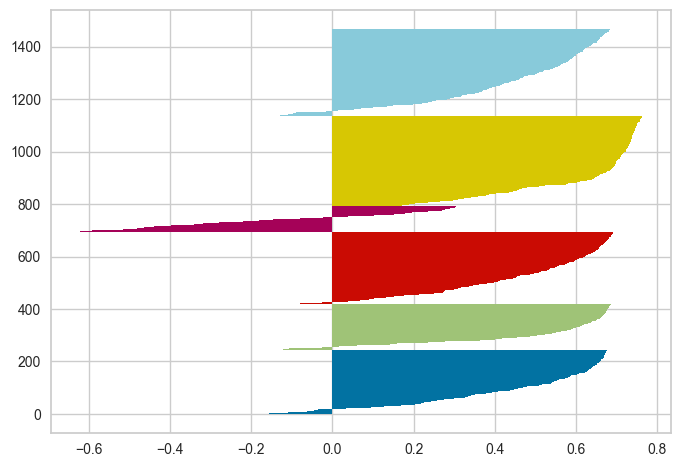

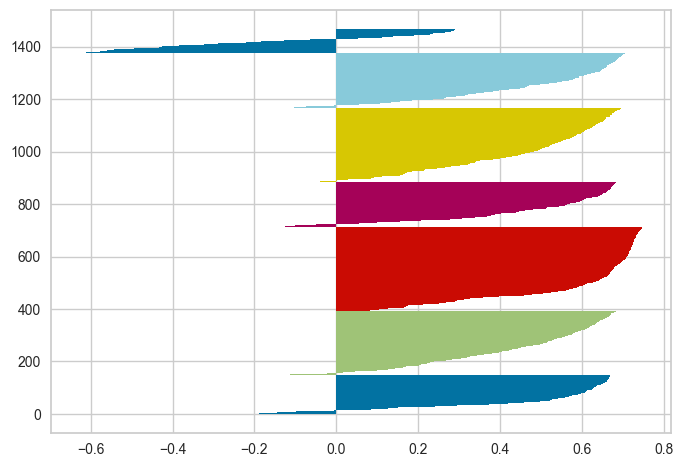

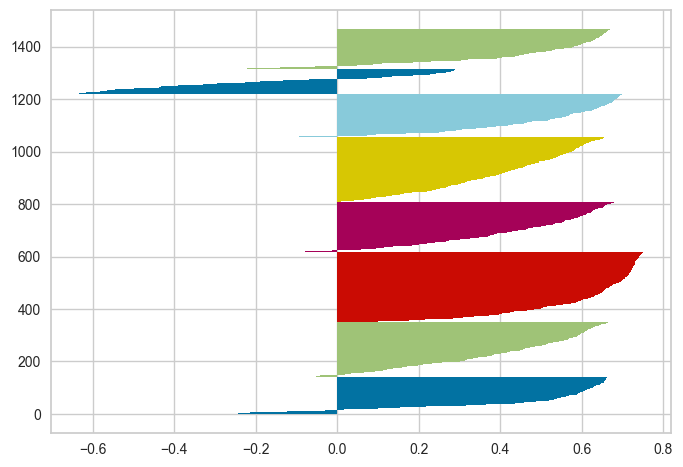

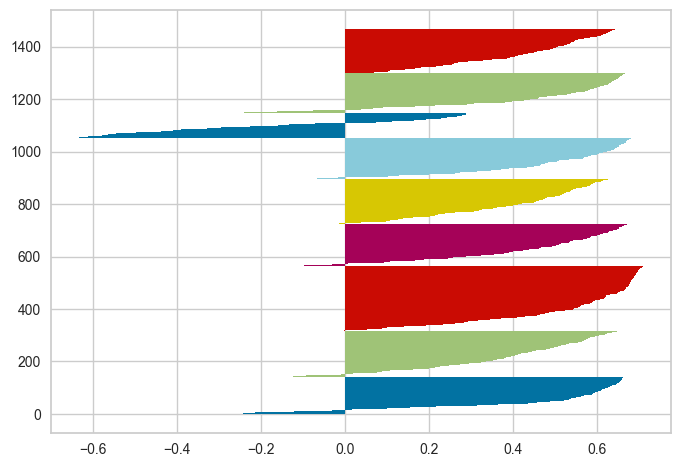

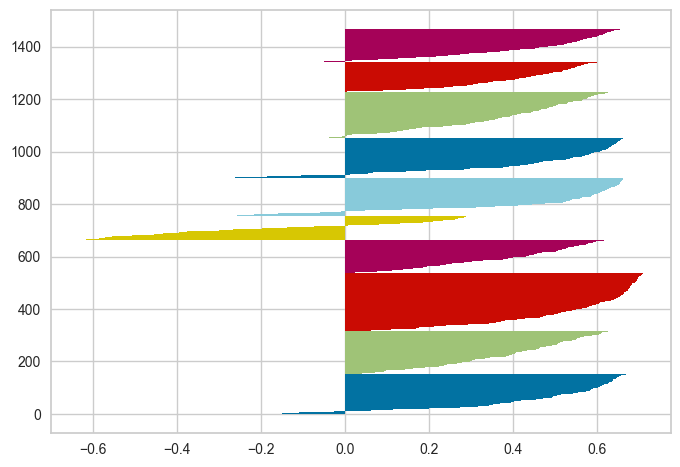

In [32]:
# 최적의 k 찾기 -> 4
from sklearn.metrics import silhouette_score, silhouette_samples

for k in range(3, 11):
    fig, ax = plt.subplots(1, 1)
    kmedoids = KMedoids(n_clusters=k, random_state=17).fit(cl_df)

    silhouette_avg = silhouette_score(cl_df, kmedoids.labels_)
    print(f'cluster : {k} // silhouette index {silhouette_avg}')

    silhouette_vals = silhouette_samples(cl_df, kmedoids.labels_)
    y_ticks = []
    y_lower = y_upper = 0
    for c_num in np.unique(kmedoids.labels_):
        cluster_silhouette_vals = silhouette_vals[kmedoids.labels_==c_num]
        y_upper += len(cluster_silhouette_vals)
        cluster_silhouette_vals.sort() # numpy array는 sort 메소드를 이용하면 오름차순으로 정렬된 형태로 바뀜

        ax.barh(range(y_lower, y_upper), cluster_silhouette_vals, height=1)
        y_lower += len(cluster_silhouette_vals)

In [33]:
from sklearn_extra.cluster import KMedoids

kmedoids = KMedoids(n_clusters=4, random_state=17)

kmedoids.fit(cl_df)

df_pv['군집'] = kmedoids.fit_predict(cl_df) 

In [34]:
df_pv['이용패턴'] = km_wod['군집']

In [35]:
df_pv

,고객ID,Accessories,Android,Apparel,Bags,Bottles,Drinkware,Gift Cards,Headgear,Housewares,...,Nest-USA,Notebooks & Journals,Office,Waze,L,R,F,M,군집,이용패턴
0,USER_0000,0.00,0.0,19.99,0.00,0.00,0.00,0.0,0.00,0.0,...,0.00,0.00,11.00,0.00,0,107,2,30.99,2,3
1,USER_0001,2.99,0.0,8902.01,27.94,0.00,31.93,0.0,37.98,0.0,...,3917.00,0.00,255.10,0.00,223,59,60,13834.90,3,3
2,USER_0002,0.00,0.0,49.74,244.39,0.00,418.24,0.0,0.00,0.0,...,475.00,0.00,224.76,0.00,119,73,23,1442.12,2,6
3,USER_0003,0.00,0.0,173.59,0.00,0.00,0.00,0.0,32.60,0.0,...,850.12,0.00,0.00,0.00,0,17,17,1360.07,2,6
4,USER_0004,0.00,0.0,276.30,4.99,0.00,47.37,0.0,0.00,0.0,...,655.00,0.00,46.81,0.00,0,107,36,1442.47,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,USER_1463,0.00,0.0,156.66,0.00,0.00,10.39,0.0,0.00,0.0,...,0.00,359.70,0.00,0.00,0,270,7,544.34,2,1
1464,USER_1464,27.18,0.0,344.32,167.97,2.39,70.36,0.0,55.81,0.0,...,1259.00,166.12,201.53,21.57,105,87,40,2363.05,0,3
1465,USER_1465,0.00,0.0,98.38,0.00,0.00,0.00,0.0,0.00,0.0,...,0.00,0.00,3.18,0.00,76,194,8,101.56,2,1
1466,USER_1466,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,...,298.00,0.00,0.00,0.00,0,69,1,298.00,2,5


In [36]:
total = df_pv.groupby('군집').agg({'L' : 'mean', 'R' : 'mean', 'F' : 'mean', 'M' : 'sum' , '고객ID' : 'count'})
total

,L,R,F,M,고객ID
군집,,,,,
0,67.922170,138.235849,30.028302,1053176.89,424
1,102.777344,123.351562,60.882812,1418197.63,256
2,26.327327,168.606607,10.286787,410998.58,666
3,178.672131,76.549180,145.532787,1788421.52,122


In [47]:
df_pv.groupby('군집').sum().reset_index().iloc[:,2:17].style.background_gradient(cmap='Greens', axis = 1)

,Accessories,Android,Apparel,Bags,Bottles,Drinkware,Gift Cards,Headgear,Housewares,Lifestyle,Nest,Nest-Canada,Nest-USA,Notebooks & Journals,Office
0,956.930000,210.370000,126265.840000,34766.540000,1446.810000,42282.940000,4083.330000,5010.920000,1713.650000,17593.190000,98991.590000,20807.350000,616568.850000,15918.640000,60557.910000
1,2018.480000,266.010000,156745.430000,40009.830000,2159.570000,51354.730000,6638.680000,7906.010000,763.970000,20255.160000,173747.820000,23773.880000,819752.280000,18382.480000,84957.290000
2,255.010000,83.150000,65690.590000,12213.840000,996.460000,21492.830000,1688.160000,3122.460000,369.100000,7826.430000,34565.380000,6191.070000,226888.100000,6665.330000,20333.310000
3,4065.460000,151.500000,242443.940000,64324.220000,2320.810000,85577.330000,7123.650000,37432.050000,1790.600000,28710.920000,210888.710000,20138.100000,890993.160000,66119.510000,110945.890000


C:\Users\zxcv2\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:82: UserWarning: Glyph 44400 (\N{HANGUL SYLLABLE GUN}) missing from current font.
  func(*args, **kwargs)
C:\Users\zxcv2\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:82: UserWarning: Glyph 51665 (\N{HANGUL SYLLABLE JIB}) missing from current font.
  func(*args, **kwargs)
C:\Users\zxcv2\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44400 (\N{HANGUL SYLLABLE GUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\zxcv2\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51665 (\N{HANGUL SYLLABLE JIB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


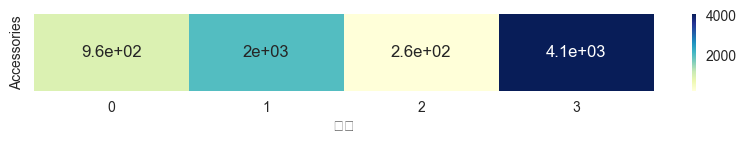

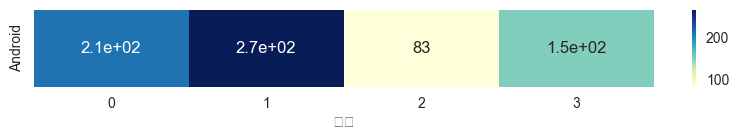

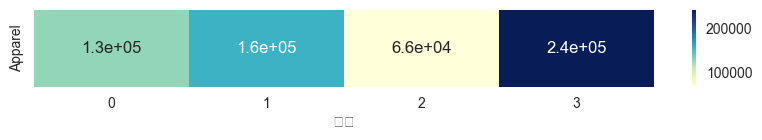

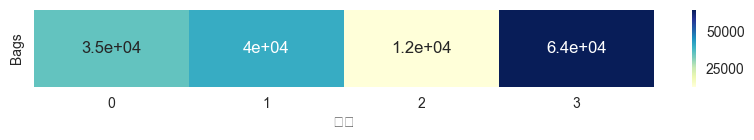

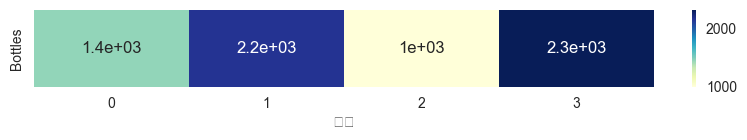

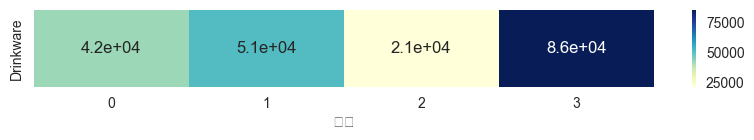

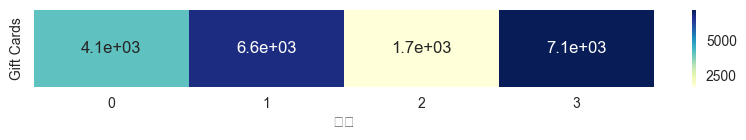

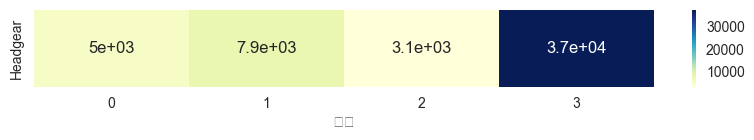

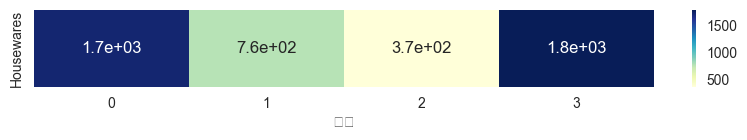

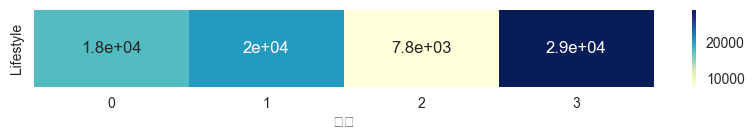

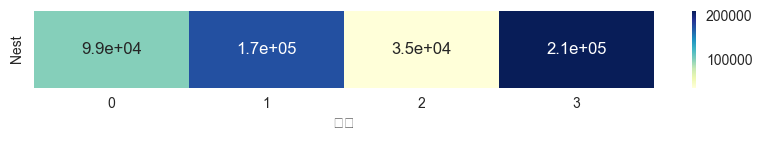

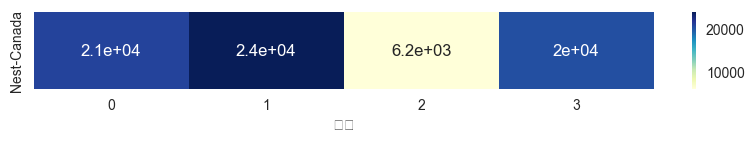

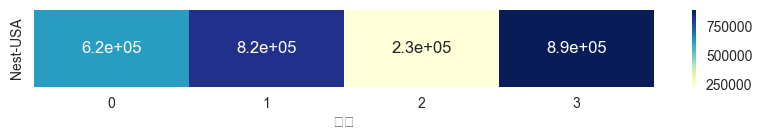

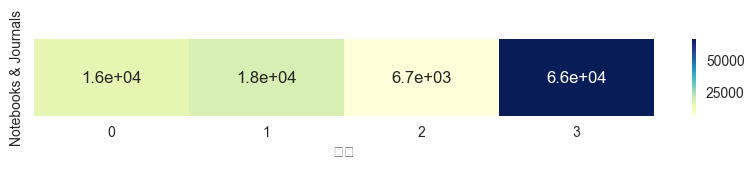

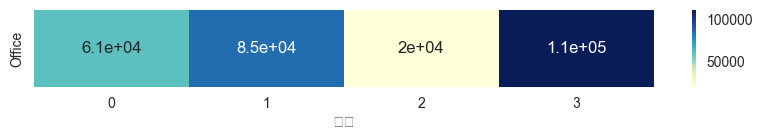

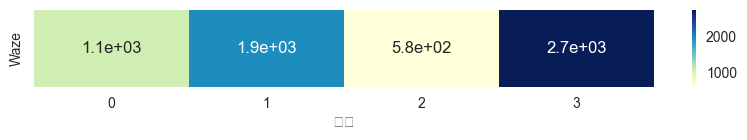

In [38]:
# 군집별 각 카테고리 소비금액 정도 알아보기
for i in range(1,17):
    plt.figure(figsize=(10,1))
    sns.heatmap(df_pv.groupby('군집').sum().reset_index().iloc[:,i+1:i+2].transpose(), cmap='YlGnBu', annot=True)
    plt.xlabel('군집')
    #plt.yticks(rotation=0)

### 연관 분석 (진행중)

In [ ]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [ ]:
df_b = sales[['고객ID', '거래날짜']]


In [ ]:
# # 거래ID별로 제품ID를 리스트로 그룹화
# transactions = sales.groupby('거래ID')['제품ID'].apply(list).values.tolist()

# # TransactionEncoder를 사용하여 데이터 변환
# encoder = TransactionEncoder()
# encoded_array = encoder.fit(transactions).transform(transactions)
# transaction_df = pd.DataFrame(encoded_array, columns=encoder.columns_)

# # apriori 알고리즘을 사용하여 빈번한 아이템 세트 찾기
# frequent_itemsets = apriori(transaction_df, min_support=0.01, use_colnames=True)

# # 연관 규칙 생성
# rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

# # 연관 규칙 출력
# print(rules.sort_values(by='confidence', ascending=False).head(10))

In [ ]:
# 군집 2
cluster_2_ids = df_pv[df_pv['군집'] == 2]['고객ID']  #군집 수정시 여기만 수정하면 됨.
df_b = df_b[df_b['고객ID'].isin(cluster_2_ids)]
df_b.head()
# 고객 ID와 거래 날짜로 그룹화한 후, 고객 ID와 거래 날짜를 기준으로 중복되는 값을 갖도록 거래 ID 부여
df_b['거래ID'] = df_b.groupby(['고객ID', '거래날짜']).ngroup() + 1
df_b.head()

In [ ]:
df_b3= pd.concat([df_b['거래ID'], sales['제품ID']], axis=1)

# 각 거래 ID에 대해 해당하는 제품 카테고리를 추출하여 하나의 리스트에 묶음
grouped_categories = df_b3.groupby('거래ID')['제품ID'].apply(list)

# 모든 리스트를 하나의 리스트로 묶어 이중리스트 생성
final_list = grouped_categories.tolist()
print(final_list)

In [ ]:
te = TransactionEncoder()
te_ary = te.fit(final_list).transform(final_list)
df_b4 = pd.DataFrame(te_ary, columns=te.columns_)

In [ ]:
frequent_itemsets = apriori(df_b4, min_support=0.3, use_colnames=True)
frequent_itemsets
# 연관 규칙 생성
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

# 연관 규칙 출력
print(rules.sort_values(by='confidence', ascending=False).head(10))

In [ ]:
# # apriori 알고리즘을 사용하여 빈번한 아이템 세트 찾기
# frequent_itemsets = apriori(transaction_df, min_support=0.01, use_colnames=True)

# # 연관 규칙 생성
# rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

# # 연관 규칙 출력
# print(rules.sort_values(by='confidence', ascending=False).head(10))

In [ ]:
lrfm.groupby('군집').mean()
# 3->1->0>2 순인가?

In [ ]:
data = df_pv.merge(lrfm, on =['고객ID'])